In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

[*********************100%***********************]  1 of 1 completed


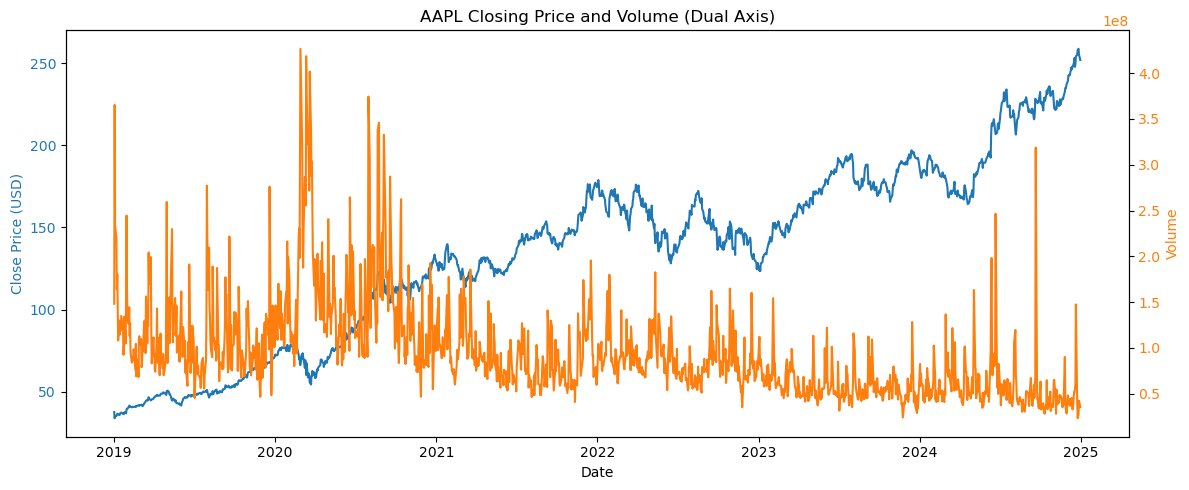

In [4]:
# Download historical data for Apple Inc. (AAPL)
df = yf.download('AAPL', start='2019-01-01', end='2024-12-31')

# Select two features: 'Close' price and 'Volume'
data = df[['Close', 'Volume']].dropna()

import matplotlib.pyplot as plt

# Ensure data has 'Close' and 'Volume' columns and datetime index
fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot Close price on left Y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price (USD)', color='tab:blue')
ax1.plot(data.index, data['Close'], color='tab:blue', label='Close Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create second Y-axis for Volume
ax2 = ax1.twinx()
ax2.set_ylabel('Volume', color='tab:orange')
ax2.plot(data.index, data['Volume'], color='tab:orange', label='Volume')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Title and legend
plt.title('AAPL Closing Price and Volume (Dual Axis)')
fig.tight_layout()
plt.show()

In [5]:
# Normalize both features to a 0-1 range
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Check shape
print("Scaled Data Shape:", data_scaled.shape)

Scaled Data Shape: (1509, 2)


In [6]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])        # Sequence of features
        y.append(data[i + window_size][0])       # Predict 'Close' price at t+1
    return np.array(X), np.array(y)

window_size = 10  # Number of previous time steps to use
X, y = create_sequences(data_scaled, window_size)

print("Input shape:", X.shape)  # (samples, time_steps, features)
print("Target shape:", y.shape)

Input shape: (1499, 10, 2)
Target shape: (1499,)


In [7]:
split_ratio = 0.8
split = int(len(X) * split_ratio)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [9]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Updated model
model = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),
    SimpleRNN(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │         4,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,353 (17.00 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.1275 - val_loss: 0.0050
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010 - val_loss: 9.8610e-04
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6975e-04 - val_loss: 6.4651e-04
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4590e-04 - val_loss: 7.0385e-04
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0238e-04 - val_loss: 8.0458e-04
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7709e-04 - val_loss: 5.3443e-04
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9741e-04 - val_loss: 4.7816e-04
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4829e-04 - val_loss: 3.6597e-04
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5840e-04 - val_loss: 3.9065e-04
Epoch 10/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6512e-04 - val_loss: 6.4559e-04
Epoch 11/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4717e-04 - val_loss: 3.8522e-

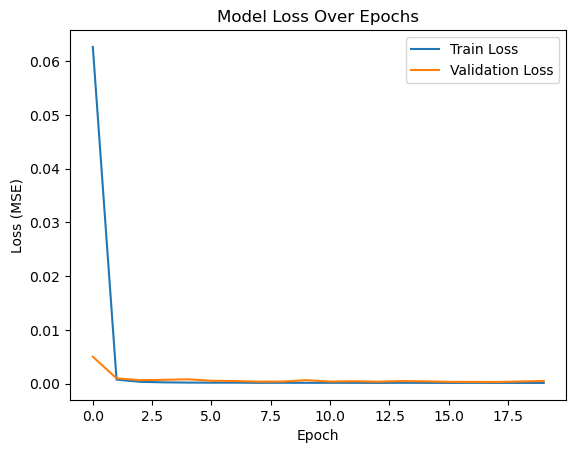

In [11]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [12]:
# Predict on test data
y_pred = model.predict(X_test)

# Invert scaling to compare actual prices (Close only)
close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[0], scaler.scale_[0]

y_test_unscaled = y_test * scaler.data_range_[0] + scaler.data_min_[0]
y_pred_unscaled = y_pred.flatten() * scaler.data_range_[0] + scaler.data_min_[0]

# Evaluation metrics
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Test MSE: 25.0369
Test MAE: 4.0078


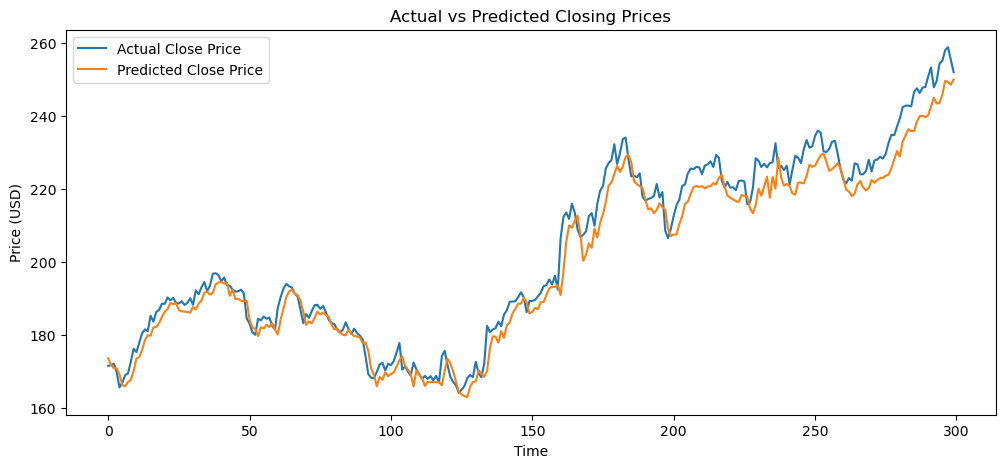

In [13]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_unscaled, label='Actual Close Price')
plt.plot(y_pred_unscaled, label='Predicted Close Price')
plt.title("Actual vs Predicted Closing Prices")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()